In [1]:
import numpy as np
import torch 
from torch import nn
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.autograd import grad
import os
from scipy import integrate
from scipy import sparse

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
# plt.rc('savefig', dpi=300)

import numpy as np
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
T = 1 # time [0, T]
N = 100 # split [0, T] into N parts
h = 1e-2 
m = 1 
sig2 = h / m 
mu = 0
d = 1 # points from R^d

In [4]:
time_splits = torch.Tensor(np.linspace(0, T, N+1)) 

In [5]:
class NN(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hid_dim) 
        self.relu1 = nn.Tanh()
        self.relu2 = nn.Tanh()
        self.fc2 = nn.Linear(hid_dim, hid_dim)  
        self.fc4 = nn.Linear(hid_dim, output_dim) 

    def forward(self, x, t):
        out = torch.hstack((x, t))
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc4(out)
        return out

We consider case of $d = 1, V = 0$ and $\psi_{0} = \delta_{0}$. We relaxed it to $\psi_{0} = \sqrt{\frac{1}{\sqrt{2\pi \alpha}}e^{-\frac{x^2}{2\alpha}}}$ with $\alpha = \frac{\hbar^2}{m^2}$. In that case $v_{0} = 0$ and $u_{0}(x) = - \frac{\hbar x}{2m\alpha}$. We consider $T = 1$, i.e. $t \in [0, 1]$. We also set $m= 1$ and $\hbar = 10^{-2}$. Since density is singular, we must set $\nu = 1$ and in applications, we use $\psi_{0} = \delta_{0}$ for generating the trajectory. We use $N = 100, B = 100$.

In [6]:
def V_x_i(x): # should be grad of V
    return torch.zeros(x.shape)

def v_0(x):
    return (h) / m * torch.zeros(x.shape).to(device)

def u_0(x):
    return -h * x / (2 * m * (sig2**2))

def time_transform(t):
    return t 

In [7]:
dim_inp = d + 1
dim_out = d
dim_hid = 200 #400
net_u = NN(dim_inp, dim_hid, dim_out).to(device);
net_v = NN(dim_inp, dim_hid, dim_out).to(device);

criterion = nn.MSELoss()
learning_rate = 0.1 #1e-3 #0.001 #1e-6 #0.01

optimizer = torch.optim.SGD([*net_u.parameters(), *net_v.parameters()], lr=learning_rate, weight_decay=0) 

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0)
alpha = 1e-2 #0.8 #100 Score
beta = 1 #1 # 0.8 Newton
gamma = 1e-2 #1e-2 # 0.8 initial

In [30]:
# 5-7k for 3d, 2k for 1d
n_iter = 5000 #2000 
iter_threshhold = 1000
batch_size = 100 #512 # 1000
loss_ref = np.inf
lines = [None, None, None]
losses = []
losses_newton = []
losses_sm = []
losses_init = []
N_fast = N

with tqdm(range(n_iter), unit="iter") as tepoch:
    for tau in tepoch:
        if tau == 0: 
#             print('Iter 0, just generate batches')
            l_sm = 0
            l_nl = 0
#             X_0 = sample_X_0(mu, np.sqrt(alpha)).to(device)
            X_0 =  torch.Tensor(np.random.multivariate_normal(np.ones(d) * mu, 
                                                             (sig2**2)*np.eye(d), batch_size)).to(device)
            X_0.requires_grad = True
            u0_val = torch.Tensor(u_0(X_0)).to(device)
            v0_val = torch.Tensor(v_0(X_0)).to(device)
            optimizer.zero_grad()
            eps = [np.random.multivariate_normal(np.zeros(d), np.eye(d), batch_size) for i in range(N+1)]
            for i in range(1, N_fast+1): # iterate over time steps
                t_prev = time_splits[i-1].clone()
                if i == 1:
                    X_prev = X_0.clone().to(device) # X_{i-1}
                else:
                    X_prev = X_i.clone().to(device) # X_{i-1}

                t_i = time_splits[i].clone()
                
                t_prev_batch = time_transform(t_prev).expand(batch_size, 1).to(device).clone()
                X_i = torch.Tensor(X_prev).to(device) + T / N * (net_u(X_prev, t_prev_batch) + \
                                                                 net_v(X_prev, t_prev_batch)) \
                        + torch.Tensor(np.sqrt(h*T/(m*N)) * eps[i-1]).to(device)
 
                if i > 1: 
                    Xs = torch.hstack((Xs, X_i))
                else:
                    Xs = X_i.clone()
   
            X_0_iter0 = X_0.clone() # collect X_0 from the initial iter
        elif tau > iter_threshhold: 
            BATCH_size = int(0.2* batch_size) #int(0.5* batch_size) 10
#             X_0_iter = sample_X_0(mu, np.sqrt(alpha)).to(device)
            
            X_0_iter = torch.Tensor(np.random.multivariate_normal(np.ones(d) * mu, 
                                                             (sig2**2)*np.eye(d), BATCH_size)).to(device)
            X_0_iter.requires_grad = True
            u0_val = torch.Tensor(u_0(X_0_iter)).to(device)
            v0_val = torch.Tensor(v_0(X_0_iter)).to(device)
            optimizer.zero_grad()
            eps = [np.random.multivariate_normal(np.zeros(d), np.eye(d), BATCH_size) for i in range(N+1)]
            # get one trajectory
            for i in range(1, N_fast+1): 
                t_prev = time_splits[i-1].clone()
                if i == 1:
                    X_prev = X_0_iter.clone().to(device) 
                else:
                    X_prev = X_i_iter.clone().to(device) 

                t_i = time_splits[i].clone()
                
                t_prev_batch = time_transform(t_prev).expand(BATCH_size, 1).to(device)
                X_i_iter = torch.Tensor(X_prev).to(device) + T / N * (net_u(X_prev, t_prev_batch) + \
                                                                 net_v(X_prev, t_prev_batch)) \
                        + torch.Tensor(np.sqrt(h*T/(m*N)) * eps[i-1]).to(device)
 
                if i > 1: 
                    Xs_iter = torch.hstack((Xs_iter, X_i_iter))
                else:
                    Xs_iter = X_i_iter.clone()
            
            # replace the old batch with the new one
            Xs_all = Xs_all.reshape((batch_size, N*d))
            X_0_all = X_0_all.reshape((batch_size, d))
            Xs_all = torch.roll(Xs_all, -BATCH_size, 0)
            X_0_all = torch.roll(X_0_all, -BATCH_size, 0)
            Xs_all = torch.vstack((Xs_all[BATCH_size:].detach(), Xs_iter.detach()) )
            Xs_all.requires_grad = True

            X_0_all = torch.vstack((X_0_all[BATCH_size:].detach(), X_0_iter.detach()) )
            X_0_all.requires_grad = True 
            
            Xs_all = Xs_all.reshape(batch_size*N, d)
            X_0_all = X_0_all.reshape(batch_size, d)
            
            time_splits_batches = time_splits[1:].repeat(batch_size).reshape(batch_size, N).reshape(batch_size*N, 1).to(device)
            time_splits_batches.requires_grad = True
            
            out_u = net_u(Xs_all, time_splits_batches)
            out_v = net_v(Xs_all, time_splits_batches)
            
            du_dt = grad(out_u, time_splits_batches, grad_outputs=torch.ones_like(out_u), create_graph=True)[0]
            dv_dt = grad(out_v, time_splits_batches, grad_outputs=torch.ones_like(out_v), create_graph=True)[0]

            dv_dx = grad(out_v, Xs_all, grad_outputs=torch.ones_like(out_v), create_graph=True)[0]
            du_dx = grad(out_u, Xs_all, grad_outputs=torch.ones_like(out_u), create_graph=True)[0]
            dv_ddx = grad(dv_dx, Xs_all, grad_outputs=torch.ones_like(dv_dx), create_graph=True)[0]
            du_ddx = grad(du_dx, Xs_all, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]

            out_uv = net_v(Xs_all, time_splits_batches) * net_u(Xs_all, time_splits_batches)
            dvu_dx = grad(out_uv, Xs_all, grad_outputs=torch.ones_like(out_uv), create_graph=True)[0]
            
            L_sm = criterion(du_dt, -(h/(2*m)) * dv_ddx - dvu_dx) 

            L_nl = criterion(dv_dt, -out_v * dv_dx + out_u * du_dx + (h / 2 / m) * du_ddx \
                               -V_x_i(Xs_all).to(device)/m) 
            
            u0_val = torch.Tensor(u_0(X_0_all)).to(device)
            v0_val = torch.Tensor(v_0(X_0_all)).to(device)
            L_ic = criterion(net_u(X_0_all, 
                                   time_splits[0].expand(batch_size, 1).to(device)), u0_val) \
                     + criterion(net_v(X_0_all, 
                                       time_splits[0].expand(batch_size, 1).to(device)), v0_val)
            
            loss = (alpha * L_sm + beta * L_nl + gamma * L_ic) / 3.0
            losses.append(loss.item())
            losses_newton.append(L_nl.item())
            losses_sm.append(L_sm.item())
            losses_init.append(L_ic.item())
            tepoch.set_postfix(loss_iter=loss.item(), loss_mean=np.mean(losses[-10:]), loss_std=np.std(losses[-10:]))

            loss.backward()
            optimizer.step()
            
        elif tau <= iter_threshhold:
            BATCH_size = int(0.6* batch_size)
#             X_0_iter = sample_X_0(mu, np.sqrt(alpha)).to(device)

            X_0_iter = torch.Tensor(np.random.multivariate_normal(np.ones(d) * mu, 
                                                             (sig2**2)*np.eye(d), BATCH_size)).to(device)
            X_0_iter.requires_grad = True
            u0_val = torch.Tensor(u_0(X_0_iter)).to(device)
            v0_val = torch.Tensor(v_0(X_0_iter)).to(device)
            optimizer.zero_grad()
            eps = [np.random.multivariate_normal(np.zeros(d), np.eye(d), BATCH_size) for i in range(N+1)]
            # get one trajectory
            for i in range(1, N_fast+1): 
                t_prev = time_splits[i-1].clone()
                if i == 1:
                    X_prev = X_0_iter.clone().to(device) 
                else:
                    X_prev = X_i_iter.clone().to(device) 

                t_i = time_splits[i].clone()

                t_prev_batch = time_transform(t_prev).expand(BATCH_size, 1).to(device)
                X_i_iter = torch.Tensor(X_prev).to(device) + T / N * (net_u(X_prev, t_prev_batch) + \
                                                                 net_v(X_prev, t_prev_batch)) \
                        + torch.Tensor(np.sqrt(h*T/(m*N)) * eps[i-1]).to(device)

                if i > 1: 
                    Xs_iter = torch.hstack((Xs_iter, X_i_iter))
                else:
                    Xs_iter = X_i_iter.clone()
            # replace the old batch with the new one
            if tau == 1:
                Xs_all = torch.vstack((Xs[BATCH_size:].detach(), Xs_iter.detach()) )
                Xs_all.requires_grad = True

                X_0_all = torch.vstack((X_0_iter0[BATCH_size:].detach(), X_0_iter.detach()) )
                X_0_all.requires_grad = True
            else:
                Xs_all = Xs_all.reshape((batch_size, N*d))
                X_0_all = X_0_all.reshape((batch_size, d))
                Xs_all = torch.roll(Xs_all, -BATCH_size, 0)
                X_0_all = torch.roll(X_0_all, -BATCH_size, 0)
                Xs_all = torch.vstack((Xs_all[BATCH_size:].detach(), Xs_iter.detach()) )
                Xs_all.requires_grad = True

                X_0_all = torch.vstack((X_0_all[BATCH_size:].detach(), X_0_iter.detach()) )
                X_0_all.requires_grad = True

            Xs_all = Xs_all.reshape(batch_size*N, d)
            X_0_all = X_0_all.reshape(batch_size, d)

            time_splits_batches = time_splits[1:].repeat(batch_size).reshape(batch_size, N).reshape(batch_size*N, 1).to(device)
            time_splits_batches.requires_grad = True

            out_u = net_u(Xs_all, time_splits_batches)
            out_v = net_v(Xs_all, time_splits_batches)
            
            du_dt = grad(out_u, time_splits_batches, grad_outputs=torch.ones_like(out_u), create_graph=True)[0]
            dv_dt = grad(out_v, time_splits_batches, grad_outputs=torch.ones_like(out_v), create_graph=True)[0]

            dv_dx = grad(out_v, Xs_all, grad_outputs=torch.ones_like(out_v), create_graph=True)[0]
            du_dx = grad(out_u, Xs_all, grad_outputs=torch.ones_like(out_u), create_graph=True)[0]
            dv_ddx = grad(dv_dx, Xs_all, grad_outputs=torch.ones_like(dv_dx), create_graph=True)[0]
            du_ddx = grad(du_dx, Xs_all, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0]

            out_uv = net_v(Xs_all, time_splits_batches) * net_u(Xs_all, time_splits_batches)
            dvu_dx = grad(out_uv, Xs_all, grad_outputs=torch.ones_like(out_uv), create_graph=True)[0]
            
            
            L_sm = criterion(du_dt, -(h/(2*m)) * dv_ddx - dvu_dx) 

            L_nl = criterion(dv_dt, -out_v * dv_dx + out_u * du_dx + (h / 2 / m) * du_ddx \
                               -V_x_i(Xs_all).to(device)/m) 

            u0_val = torch.Tensor(u_0(X_0_all)).to(device)
            v0_val = torch.Tensor(v_0(X_0_all)).to(device)
            L_ic = criterion(net_u(X_0_all, 
                                   time_splits[0].expand(batch_size, d).to(device)), u0_val) \
                     + criterion(net_v(X_0_all, 
                                       time_splits[0].expand(batch_size, d).to(device)), v0_val)

            loss = (alpha * L_sm + beta * L_nl + gamma * L_ic) / 3.0
            losses.append(loss.item())
            losses_newton.append(L_nl.item())
            losses_sm.append(L_sm.item())
            losses_init.append(L_ic.item())
            tepoch.set_postfix(loss_iter=loss.item(), loss_mean=np.mean(losses[-10:]), loss_std=np.std(losses[-10:]))
            
            loss.backward(retain_graph=True)
            optimizer.step()
        else:
            print('NO CHOICE')


100%|███████████████████████████████████████████████████████████████████| 5000/5000 [06:04<00:00, 13.70iter/s, loss_iter=0.000688, loss_mean=0.000714, loss_std=7.73e-5]


In [154]:
# torch.save(net_u.to('cpu'), 'net_u_toy_1d_batch.pth')
# torch.save(net_v.to('cpu'), 'net_v_toy_1d_batch.pth')

In [8]:
net_u = torch.load('net_u_toy_1d_batch.pth')
net_v = torch.load('net_v_toy_1d_batch.pth')
net_u.to(device); net_v.to(device);

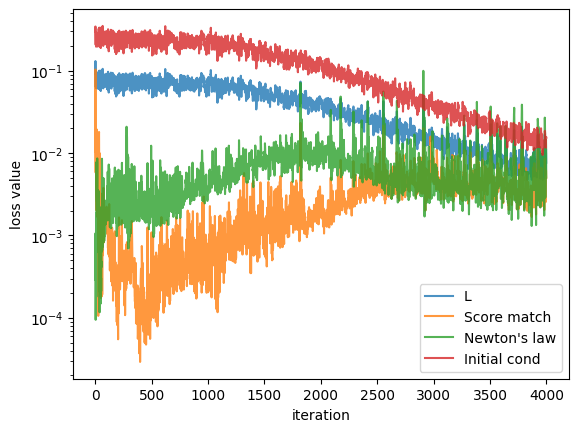

In [24]:
plt.plot(losses, alpha=0.8, label='L')
plt.plot(losses_sm, alpha=0.8,  label='Score match')
plt.plot(losses_newton, alpha=0.8,  label='Newton\'s law')
plt.plot(losses_init, alpha=0.8,  label='Initial cond')
plt.xlabel('iteration')
plt.ylabel('loss value')
plt.yscale('log')
plt.legend();

In [12]:
def plot_stats(x, m, v, t, sol_m, sol_v):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 4)
    x = time_splits.numpy()

    axs[0].plot(x, m.mean(axis=0), color='green', label='preds', linewidth=0.8)
#     axs[0].plot(x, m.mean(axis=0) - m.std(axis=0), linestyle='--', color='seagreen', linewidth=0.8)
#     axs[0].plot(x, m.mean(axis=0) + m.std(axis=0), linestyle='--', color='seagreen', linewidth=0.8)
    axs[0].fill_between(x, m.mean(axis=0) - m.std(axis=0), 
                        m.mean(axis=0) + m.std(axis=0), color='seagreen', 
                        alpha=0.5, linewidth=0.8)
    axs[0].plot(t, sol_m, color='black', linestyle='--', label='truth', linewidth=0.8)
    axs[0].set_ylabel('value')
    axs[0].set_xlabel('time')
    axs[0].set_ylim(-0.1, 0.1)
    axs[0].legend();
    axs[0].set_title('$X_t$ mean')

    axs[1].plot(x, v.mean(axis=0), color='dodgerblue', label='preds', linewidth=0.8)
    axs[1].plot(x, v.mean(axis=0) - v.std(axis=0), linestyle='--', color='dodgerblue', linewidth=0.8)
    axs[1].plot(x, v.mean(axis=0) + v.std(axis=0), linestyle='--', color='dodgerblue', linewidth=0.8)
    axs[1].fill_between(x, v.mean(axis=0) - v.std(axis=0), 
                        v.mean(axis=0) + v.std(axis=0), color='dodgerblue', 
                        alpha=0.5, linewidth=0.8)
    axs[1].plot(t, sol_v, color='black', linestyle='--', label='truth', linewidth=0.8)
    axs[1].set_title('$X_t$ variance') 
    axs[1].set_xlabel('time')
    axs[1].legend();

In [15]:
net_u.eval();
net_v.eval();

samples = 10000
# N = 100
num_trials = 10
X_test = np.zeros((num_trials, N+1, samples, d))

# can change nu value for sampling
# nu = 0 no u and noise during sampling (but still running net_u(x))
nu_s = 1

for trial in range(num_trials):
    with torch.no_grad():
        X_0 = torch.Tensor(np.random.multivariate_normal(np.ones(d) * mu, (sig2**2)*np.eye(d), samples)).to(device)
        X_test[trial, 0, :] = X_0.cpu().numpy()
        X_prev = X_0.clone()
        eps = [np.random.multivariate_normal(np.zeros(d), np.eye(d), samples) for i in range(N)]    
        for i in range(1, N+1):
            a = torch.hstack((X_prev, time_splits[i-1].expand(samples, 1).to(device)))
            X_i = torch.Tensor(X_prev).to(device) + T / N * \
            (nu_s * net_u(X_prev, time_splits[i-1].expand(samples, 1).to(device)) \
             + net_v(X_prev, time_splits[i-1].expand(samples, d).to(device))) \
                       + torch.Tensor(np.sqrt((h*T * nu_s)/(m*N)) * eps[i-1]).to(device)
            X_test[trial, i, :] = X_i.cpu().numpy()
            X_prev = X_i.clone()

In [16]:
mean_trials = np.zeros((num_trials, N + 1, d))
var_trials = np.zeros((num_trials, N + 1, d))

for trial in range(num_trials):
    mean_trials[trial] = X_test[trial].mean(axis=1)
    var_trials[trial] = X_test[trial].var(axis=1)

In [17]:
bmeans = np.zeros(N+1)
bstds = (h/ m) * np.linspace(0, 1, N+1)

In [18]:
dx    = np.sqrt(1 / 1000) # np.sqrt(T / 1000)    100000                    # spatial separation
x     = np.arange(0, 1, dx) 

In [19]:
plt.rcParams.update({'font.size': 12})

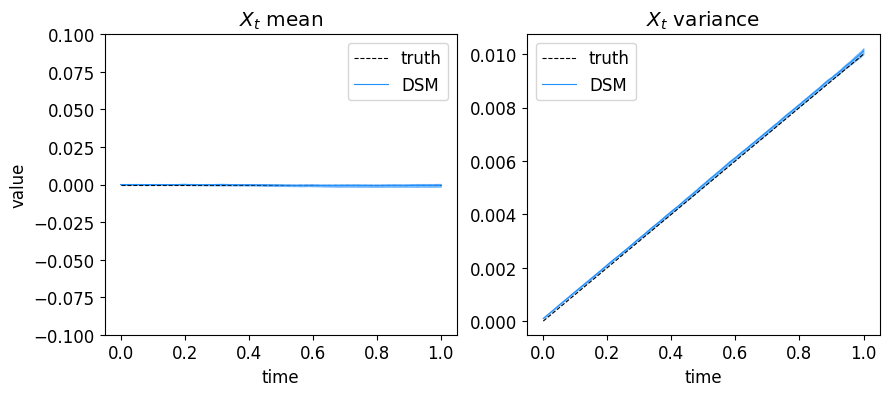

In [24]:
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10, 3.9)
# fig.set_size_inches(8.5, 3)
x = time_splits.numpy()

axs[0].plot(x, bmeans, color='black', linestyle='--', label='truth', linewidth=0.8)
axs[0].plot(x, mean_trials[:, :, 0].mean(axis=0), color='dodgerblue', label='DSM', linewidth=0.8)
axs[0].fill_between(x, mean_trials[:, :, 0].mean(axis=0) - mean_trials[:, :, 0].std(axis=0), 
                    mean_trials[:, :, 0].mean(axis=0) + mean_trials[:, :, 0].std(axis=0), color='dodgerblue', 
                    alpha=0.5, linewidth=0.8)
axs[0].set_ylim(-0.1, 0.1)
# axs[0].plot(x, bmeans_pinn, color='seagreen', label='PINN', linewidth=0.8)
axs[0].set_ylabel('value')
axs[0].set_xlabel('time')
axs[0].legend();
axs[0].set_title('$X_t$ mean')

axs[1].plot(x, bstds, color='black', linestyle='--', label='truth', linewidth=0.8)
axs[1].plot(x, var_trials[:, :, 0].mean(axis=0), color='dodgerblue', label='DSM', linewidth=0.8)
axs[1].fill_between(x, var_trials[:, :, 0].mean(axis=0) - var_trials[:, :, 0].std(axis=0), 
                    var_trials[:, :, 0].mean(axis=0) + var_trials[:, :, 0].std(axis=0), color='dodgerblue', 
                    alpha=0.5, linewidth=0.8)
# axs[1].plot(x, bstds_pinn, color='seagreen', label='PINN', linewidth=0.8)
axs[1].set_title('$X_t$ variance') 
axs[1].set_xlabel('time')
axs[1].legend();

# plt.savefig('pics/singular_1d_stats.pdf',bbox_inches='tight')

plt.show();

In [20]:
def dens_sol(x, t):
    sol = []
    for i in range(len(t)):
        if t[i] < 1e-3:
            print("!")
            sol.append(np.sqrt((1 / (np.sqrt(2*np.pi*(h)*t[i]) + 1e-5)) * np.exp(-x**2/(2*(h**0.5)*t[i] + 1e-5))))
        else:
            sol.append(np.sqrt((1 / (np.sqrt(2*np.pi*h*t[i]))) * np.exp(-x**2/(2*h*t[i]))))
    sol = np.vstack(sol)
    return sol

In [21]:
t_grid = np.linspace(0, 1, 101).astype(float)
dx_num    = np.sqrt(1 / 10000) # np.sqrt(T / 1000)    100000                    # spatial separation
x_num     = np.arange(-0.5, 0.5, dx_num)
print(x_num.shape)
dens_num = np.abs(dens_sol(x_num, t_grid))**2

(100,)
!


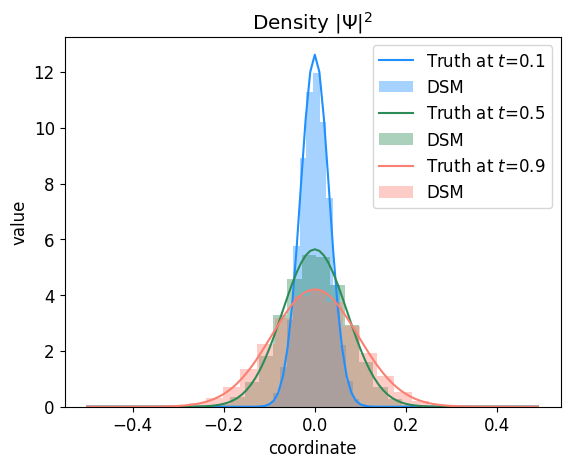

In [23]:
t_step=10
plt.plot(x_num, dens_num[t_step, :], color="dodgerblue", label='Truth at $t$={}'.format(t_grid[t_step]))
plt.hist(X_test[0:5, t_step, :, 0].reshape(-1), bins=20, color="dodgerblue", density=True, alpha=0.4, 
         label='DSM');
# plt.plot(x_pinn, dens_pinn[t_step, :],'--', color="dodgerblue", label='PINN')

t_step=50
plt.plot(x_num, dens_num[t_step, :], color="seagreen", label='Truth at $t$={}'.format(t_grid[t_step]))
plt.hist(X_test[0:5, t_step, :, 0].reshape(-1), bins=20, color="seagreen", density=True, alpha=0.4, 
         label='DSM');
# plt.plot(x_pinn, dens_pinn[t_step, :],'--', color="seagreen")

# t_step=500
# plt.plot(x, dens_num[t_step, :], color="purple", label='Truth at $t$={}'.format(t_step))
# plt.hist(X_test[0:3, t_step, :, 2].reshape(-1), bins=20, color="purple", density=True, alpha=0.4);
# plt.plot(x_pinn, dens_pinn[t_step, :].reshape(-1),'--', color="purple")
# plt.legend();

t_step=90
plt.plot(x_num, dens_num[t_step, :], color="salmon", label='Truth at $t$={}'.format(t_grid[t_step]))
plt.hist(X_test[0:5, t_step, :, 0].reshape(-1), bins=20, color="salmon",  density=True, alpha=0.4, 
         label='DSM');
# plt.plot(x_pinn, dens_pinn[t_step, :].reshape(-1),'--', color="salmon")
plt.xlabel('coordinate')
plt.ylabel('value')
plt.legend();
plt.title('Density $|\Psi|^2$');
# plt.savefig('pics/toy_1d_dens_hist.pdf',bbox_inches='tight')

In [24]:
i = 0 
err_mean_xt = (np.linalg.norm(mean_trials[:, :, i] - bmeans, axis=1)).mean()
err_mean_xt_std = (np.linalg.norm(mean_trials[:, :, i] - bmeans, axis=1)).mean()

err_std_xt = (np.linalg.norm(var_trials[:, :, i] - bstds, axis=1) / (np.linalg.norm(bstds))).mean()
err_std_std = (np.linalg.norm(var_trials[:, :, i] - bstds, axis=1) / (np.linalg.norm(bstds))).std()
print('1D Err(mean(X_t)_NN, mean(X_t)_num): ', err_mean_xt, err_mean_xt_std)
print('1D Err(var(X_t)_NN, var(X_t)_num): ', err_std_xt, err_std_std)

1D Err(mean(X_t)_NN, mean(X_t)_num):  0.00926836501057538 0.00926836501057538
1D Err(var(X_t)_NN, var(X_t)_num):  0.018988271554764947 0.0037073692101311714


In [41]:
n_bins = len(x_num)
p = np.zeros((len(time_splits), n_bins))
for i in range(len(time_splits)):
    p[i, :] = np.histogram(X_test[0:9, i, :, 0].reshape(-1), 
                           density=True, bins=n_bins, range=(lb[0], ub[0]))[0]

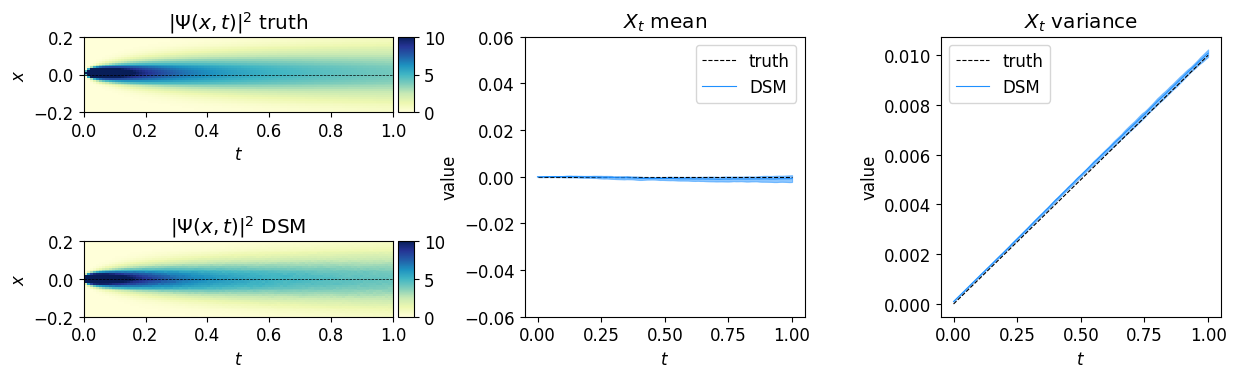

In [63]:
fig = plt.figure(figsize=(15, 4))  
# gs0 = gridspec.GridSpec(6, 5)
gs0 = gridspec.GridSpec(2, 6)
# gs0.update(top=0.9, bottom=0.4, wspace=1.2, hspace=20)
gs0.update(top=0.9, bottom=0.2, wspace=0.7, hspace=1.7)
# gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0.5, hspace=0.5)
ax1 = plt.subplot(gs0[1-1, :2])
ax2 = plt.subplot(gs0[2-1, :2])
# ax3 = plt.subplot(gs0[3-1, :2])
ax4 = plt.subplot(gs0[:3, 2:4])
ax5 = plt.subplot(gs0[:3, 4:6])

h_1 = ax1.axhline(0, linestyle='--', color='black', linewidth=0.5)
h_1 = ax1.imshow(dens_num_plot.T, cmap='YlGnBu', interpolation='nearest', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto', vmin=0, vmax=10)

# h_.clim(0, 1.5)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_1, cax=cax)

# ax.set_ylim(-0.3, 0.3)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x$')
ax1.set_title('$|\Psi(x, t)|^2$ truth');


h_2 = ax2.axhline(0, linestyle='--', color='black', linewidth=0.5)
h_2 = ax2.imshow(p.T, cmap='YlGnBu', interpolation='nearest', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto', vmin=0, vmax=10)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_2, cax=cax)
ax2.set_xlabel('$t$')
ax2.set_ylabel('$x$')
ax2.set_title('$|\Psi(x, t)|^2$ DSM');

# h_3 = ax3.axhline(0, linestyle='--', color='black', linewidth=0.5)
# h_3 = ax3.imshow(dens_pinn.T[x_half-k: x_half+k, :], cmap='YlGnBu', interpolation='nearest', 
#               extent=[lb[1], ub[1], x[x_half-k], x[x_half+k]], 
#               origin='lower', aspect='auto', vmin=0.5, vmax=2.33)
# divider = make_axes_locatable(ax3)
# cax = divider.append_axes("right", size="5%", pad=0.05)
# fig.colorbar(h_3, cax=cax)
# ax3.set_ylabel('$x$')
# ax3.set_xlabel('$t$')
# ax3.set_title('$|\Psi(x, t)|^2$ PINN');

h_4 = ax4.plot(time_splits, bmeans, color='black', linestyle='--', label='truth', linewidth=0.8)
h_4 = ax4.plot(time_splits, mean_trials[:, :, 0].mean(axis=0), color='dodgerblue', label='DSM', linewidth=0.8)
h_4 = ax4.fill_between(time_splits, mean_trials[:, :, 0].mean(axis=0) - mean_trials[:, :, 0].std(axis=0), 
                    mean_trials[:, :, 0].mean(axis=0) + mean_trials[:, :, 0].std(axis=0), color='dodgerblue', 
                    alpha=0.5, linewidth=0.8)
# h_4 = ax4.plot(time_splits, bmeans_pinn, color='seagreen', label='PINN', linewidth=0.8)
leg = ax4.legend( loc = 'best')
ax4.set_ylim(-0.06, 0.06)
ax4.set_box_aspect(1)
ax4.set_ylabel('value')
ax4.set_xlabel('$t$')
ax4.set_title('$X_t$ mean');

h_5 = ax5.plot(time_splits, bstds, color='black', linestyle='--', label='truth', linewidth=0.8)
h_5 = ax5.plot(time_splits, var_trials[:, :, 0].mean(axis=0), color='dodgerblue', label='DSM', linewidth=0.8)
h_5 = ax5.fill_between(time_splits, var_trials[:, :, 0].mean(axis=0) - var_trials[:, :, 0].std(axis=0), 
                    var_trials[:, :, 0].mean(axis=0) + var_trials[:, :, 0].std(axis=0), color='dodgerblue', 
                    alpha=0.5, linewidth=0.8)
# h_5 = ax5.plot(time_splits, bstds_pinn, color='seagreen', label='PINN', linewidth=0.8)
leg = ax5.legend( loc = 'best')
ax5.set_box_aspect(1)
ax5.set_ylabel('value')
ax5.set_xlabel('$t$')
ax5.set_title('$X_t$ variance');

# plt.savefig('pics/harm_osc_1d_all_toy_plots.pdf',bbox_inches='tight')